# CZ3005 Project 1 - Balancing a Pole on a Cart

### Done by: Zon Liew (U1921098F), Charlotte Teo (U2022021G), Paul Low (U2022421F)

Objectives:
Apply Linear annealed policy with the EpsGreedyQPolicy as the inner policy:
Achieve a DQN model that trains in the least possible number of episodes.
Balance pole on the cart for 500 steps for 100 consecutive episodes while testing.

Epsilon-Greedy chooses the optimal action at each step, but sometimes randomly chooses an unlikely option.
We specify an initially high exploration rate (epsilon) of 1 at the beginning of Q function training because we know nothing about the importance of the Q table. Epsilon value is decreased as the agent has more confidence in the Q values.

A DQN agent can be used in any environment which has a discrete action space.
It is based on the Q - Network, a neural network model that can learn to predict Q-Values (expected returns) for all actions, given an observation from the environment.

The hyperparameters are:

Size of 1st fully connected layer: 256
Size of 2nd fully connected layer: 512
Period of the update of the target network parameters: 1000 steps
Discount factor: 0.99
Decay factor for epsilon in epsilon-greedy policy: 0.99
Minimum epsilon in epsilon-greeddy policy: 1E-4
Learning rate: 3E-4
Size of replay memory: 1000000
Period of experience replay: 4 steps
PER alpha: 0.2
PER beta0: 0.4



## Task 1


In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&z

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 59.5 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.3.0
    Uninstalling pygame-2.3.0:
      Successfully uninstalled pygame-2.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/bin/bash: z: ambiguous redirect


# Import Dependencies

In [2]:
import gym
from gym import logger as gymlogger
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

In [3]:
#Install keras rl2 which seamlessly integrates with the  OpenAI Gym  to evaluate and play around with DQN Algorithm

!pip install rl-agents==0.1.1
!pip install keras-rl2
!pip install dopamine-rl



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.2 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.17.3-py3-none-any.whl size=1654650 sha256=1d89be094caaeeab8b254fb93b21ebfeca04800b5e31d27ef9c5ce4432e2e2fa
  Stored in directory: /root/.cache/pip/wheels/5d/06/a4/57a926b2e87a5e1f21551577750549206dde639e19a5ac72d5
Successfully built gym
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 2.2.1
    Uninstalling cloudpickle-2.2.1:
      Successfully uninstalled cloudpickle-2.2.1
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 KB 2.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import matplotlib.pyplot as plt
import keras
from keras import Sequential
from keras.layers import Input, Flatten, Dense
import numpy as np
from rl.memory import SequentialMemory
from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from tensorflow.keras.optimizers import Adam

# Initialisation of Cartpole Environment
Loaded from Open AI gym suite

In [5]:
#Load the CartPole environment from the OpenAI Gym suite
env = gym.make("CartPole-v1")

In [6]:
#Resets the environment to an initial state and returns the initial observation.
initial_observation = env.reset()
print("Initial observation:", initial_observation)
cumulative_reward = 0
done = False


Initial observation: [-0.02765606  0.04813557  0.01962801  0.04544257]


Observation corresponds to  'cart position', 'cart velocity', 'pole angle', and 'pole velocity' respectively.


# Initialisation of Agent

Setup of Deep Q-Network (DQN) agent using Keras-RL library for reinforcement learning.

Important functions used include:
1. SequentialMemory: This sets up an experience replay buffer with a capacity limit of 50,000 and a window length of 1. The buffer stores the agent's experiences so that they can be randomly sampled during the training process.
2. LinearAnnealedPolicy: This sets up the exploration policy for the agent. It uses the EpsGreedyQPolicy as the inner policy which selects actions based on a trade-off between exploration and exploitation. The LinearAnnealedPolicy gradually decreases the exploration rate (eps) from 1.0 to 0.1 over 10,000 steps.
3. Sequential: This sets up a feed-forward neural network model for the DQN. It has an input layer with a shape of (1, env.observation_space.shape[0]), which means it takes in a single observation vector of length env.observation_space.shape[0]. The hidden layers have 256 and 128 nodes respectively and use the ReLU activation function. The output layer has a number of nodes equal to the number of actions in the action space, and uses the linear activation function.
4. DQNAgent: This sets up the DQN agent using the previously defined model, memory, policy, and other hyperparameters such as the number of warmup steps and the target model update rate. The enable_dueling_network argument is set to True, which means the agent will use a dueling architecture to estimate the Q-values of each action.



In [7]:
#Building DQN Agent with Keras-RL
# setup experience replay buffer
memory = SequentialMemory(limit=50000, window_length=1)

# setup the Linear annealed policy with the EpsGreedyQPolicy as the inner policy
policy =  LinearAnnealedPolicy(inner_policy=  EpsGreedyQPolicy(),   # policy used to select actions
                               attr='eps',                          # attribute in the inner policy to vary             
                               value_max=1.0,                       # maximum value of attribute that is varying
                               value_min=0.1,                       # minimum value of attribute that is varying
                               value_test=0.05,                     # test if the value selected is < 0.05
                               nb_steps=10000)                      # the number of steps between value_max and value_min

#Feed-Forward Neural Network Model for Deep Q Learning (DQN)
model = Sequential()
#print(env.observation_space)
#Input is 1 observation vector, and the number of observations in that vector 
model.add(Input(shape=(1,env.observation_space.shape[0])))
model.add(Flatten())
#Hidden layers with 24 nodes each
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
#Output is the number of actions in the action space
model.add(Dense(env.action_space.n, activation='linear')) 


#Feed-Forward Neural Network Architecture Summary
print(model.summary())

#Defining DQN Agent for DQN Model
dqn = DQNAgent(model=model,                     # Q-Network model
               nb_actions=env.action_space.n,   # number of actions
               memory=memory,                   # experience replay memory
               nb_steps_warmup=25,              # how many steps are waited before starting experience replay
               target_model_update=1e-2,        # how often the target network is updated
               policy=policy,                   # the action selection policy
              enable_dueling_network=True)                   

# Configure and compile agent. 
#Use built-in tensorflow.keras Adam optimizer and evaluation metrics            
#Adam._name = 'Adam'
dqn.compile(keras.optimizers.Adam(learning_rate=2.5e-4,epsilon = 0.01), metrics = ["mse",'accuracy'])



     

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 256)               1280      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 34,434
Trainable params: 34,434
Non-trainable params: 0
_________________________________________________________________
None


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


# Training 

In [8]:
#Finally fit and train the agent
#Verbose parameter controls how much information is printed during training. A value of 10 means that training progress is printed every 10 steps.
history = dqn.fit(env, nb_steps=5000, visualize=False, verbose=10)


/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Training for 5000 steps ...
   14/5000: episode: 1, duration: 0.193s, episode steps:  14, steps per second:  73, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.357 [0.000, 1.000],  loss: --, mse: --, accuracy: --, mean_q: --, mean_eps: --


/usr/local/lib/python3.9/dist-packages/rl/memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')
/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 26 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 27 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)

   66/5000: episode: 2, duration: 1.875s, episode steps:  52, steps per second:  28, episode reward: 52.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.519 [0.000, 1.000],  loss: 0.471802, mse: 0.475270, accuracy: 0.465625, mean_q: 0.089675, mean_eps: 0.995905
   76/5000: episode: 3, duration: 0.139s, episode steps:  10, steps per second:  72, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.700 [0.000, 1.000],  loss: 0.405167, mse: 0.418941, accuracy: 0.531250, mean_q: 0.193447, mean_eps: 0.993655
   96/5000: episode: 4, duration: 0.267s, episode steps:  20, steps per second:  75, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.500 [0.000, 1.000],  loss: 0.388642, mse: 0.411855, accuracy: 0.523438, mean_q: 0.250507, mean_eps: 0.992305
  110/5000: episode: 5, duration: 0.190s, episode steps:  14, steps per second:  74, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.357 [0.000, 1.000],  loss

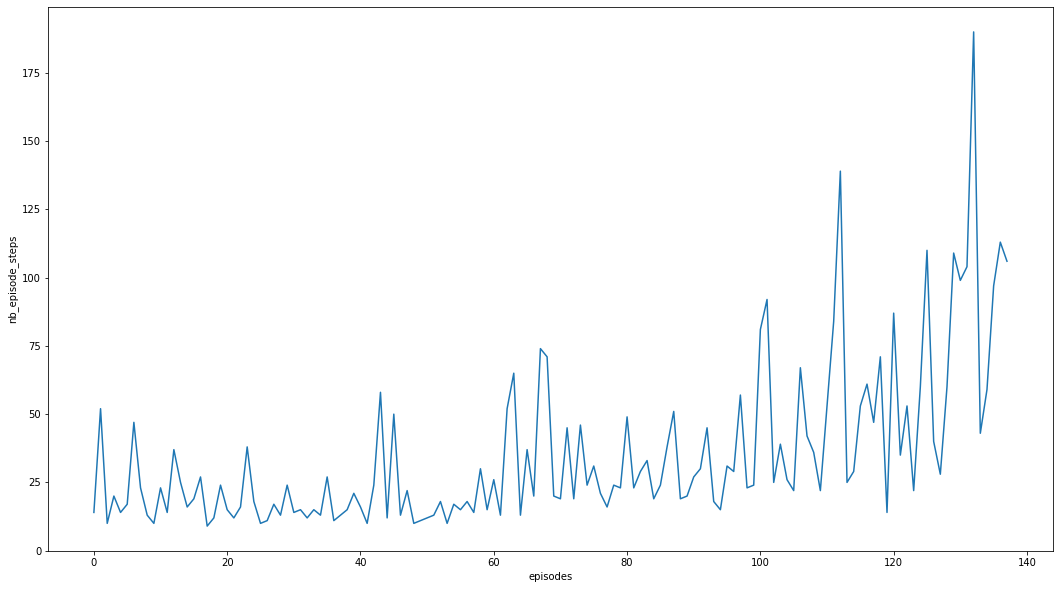

In [9]:
# Visualize the history for number of Training episode steps of the Cart Pole Game
plt.figure(figsize = (18,10))
plt.plot(history.history['nb_episode_steps'])
plt.ylabel('nb_episode_steps')
plt.xlabel('episodes')
plt.show()


# Testing

In [10]:
# Finally, evaluate and test our algorithm for 100 episodes.
dqn.test(env, nb_episodes=100, visualize=False)

Testing for 100 episodes ...
Episode 1: reward: 327.000, steps: 327
Episode 2: reward: 500.000, steps: 500
Episode 3: reward: 200.000, steps: 200
Episode 4: reward: 256.000, steps: 256
Episode 5: reward: 321.000, steps: 321
Episode 6: reward: 269.000, steps: 269
Episode 7: reward: 238.000, steps: 238
Episode 8: reward: 245.000, steps: 245
Episode 9: reward: 366.000, steps: 366
Episode 10: reward: 208.000, steps: 208
Episode 11: reward: 440.000, steps: 440
Episode 12: reward: 374.000, steps: 374
Episode 13: reward: 500.000, steps: 500
Episode 14: reward: 236.000, steps: 236
Episode 15: reward: 269.000, steps: 269
Episode 16: reward: 213.000, steps: 213
Episode 17: reward: 393.000, steps: 393
Episode 18: reward: 500.000, steps: 500
Episode 19: reward: 403.000, steps: 403
Episode 20: reward: 313.000, steps: 313
Episode 21: reward: 299.000, steps: 299
Episode 22: reward: 247.000, steps: 247
Episode 23: reward: 500.000, steps: 500
Episode 24: reward: 273.000, steps: 273
Episode 25: reward: 

In [11]:
# After training is done, we save the final weights.
dqn.save_weights('dqn_weights.h5f', overwrite=False)

In [12]:
observation = env.reset()
dqn.load_weights('dqn_weights.h5f')
action = dqn.forward(observation)

print("Observation: ", observation)
print("Chosen action: ", action)

new_observation, reward, done, info = env.step(action)
print("Observations after action: ", new_observation)
print("Reward for this step: ", reward)
print("Episode Completion: ", done)

Observation:  [-0.03007117  0.04711345  0.01588365  0.00458632]
Chosen action:  1
Observations after action:  [-0.0291289   0.24200405  0.01597538 -0.28304311]
Reward for this step:  1.0
Episode Completion:  False


## Task 2

Each Episode comprises of multiple steps. The environment is reset at the start of each episode as required. Next, the Agent makes the forward step based on the observation, before updating the new episode reward and observation for the next step. This continues until the termination criteria or truncation value of 500. Each cumulative reward is stored in a list and mapped out in the graph.

In [13]:
num_episodes = 100
episode_results = []
dqn.load_weights('dqn_weights.h5f')
for i in range(1,num_episodes+1):
    # Reset environment at the beginning of each episode
    observation = env.reset()
    cumulative_reward = 0
    done = False

    while not done:
        # Agent takes action based on observation
        action = dqn.forward(observation)
        
        # Environment processes action and returns new observation, reward, and done flag
        new_observation, reward, done, info = env.step(action)

        # Update episode reward and observation for next step
        observation = new_observation
        cumulative_reward += reward
        
    print("Episode:", i, " Cumulative reward: ", cumulative_reward)
    episode_results.append(cumulative_reward)

Episode: 1  Cumulative reward:  339.0
Episode: 2  Cumulative reward:  352.0
Episode: 3  Cumulative reward:  200.0
Episode: 4  Cumulative reward:  387.0
Episode: 5  Cumulative reward:  324.0
Episode: 6  Cumulative reward:  327.0
Episode: 7  Cumulative reward:  213.0
Episode: 8  Cumulative reward:  194.0
Episode: 9  Cumulative reward:  423.0
Episode: 10  Cumulative reward:  303.0
Episode: 11  Cumulative reward:  186.0
Episode: 12  Cumulative reward:  257.0
Episode: 13  Cumulative reward:  193.0
Episode: 14  Cumulative reward:  191.0
Episode: 15  Cumulative reward:  268.0
Episode: 16  Cumulative reward:  298.0
Episode: 17  Cumulative reward:  193.0
Episode: 18  Cumulative reward:  290.0
Episode: 19  Cumulative reward:  281.0
Episode: 20  Cumulative reward:  292.0
Episode: 21  Cumulative reward:  387.0
Episode: 22  Cumulative reward:  267.0
Episode: 23  Cumulative reward:  289.0
Episode: 24  Cumulative reward:  258.0
Episode: 25  Cumulative reward:  229.0
Episode: 26  Cumulative reward:  3

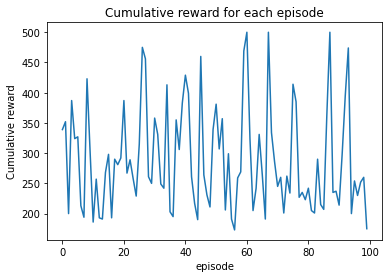

In [14]:
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

In [15]:
mean = sum(episode_results) / len(episode_results)
print("Average cumulative reward:", mean)
print("Is my agent good enough?", mean > 195)

Average cumulative reward: 289.56
Is my agent good enough? True


## Task 3
Render an episode played by the developed RL agent

In [16]:
!pip install pyvirtualdisplay
! pip install pyglet==1.5.27
!pip install pyopengl
from gym.wrappers import RecordVideo
import os
os.environ["PYGLET_NO_AVLIB"] = "1"
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()


env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    #your agent goes here
    action = dqn.forward(observation)
    observation, reward, done, info = env.step(action) 
    if done: 
      break;    
env.close()
show_video()
     

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.3 MB/s eta 0:00:00
  Attempting uninstall: pyglet
    Found existing installation: pyglet 1.5.0
    Uninstalling pyglet-1.5.0:
      Successfully uninstalled pyglet-1.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gym 0.17.3 requires pyglet<=1.5.0,>=1.4.0, but you have pyglet 1.5.27 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
